# Local thickness

This example explains how to use the ``local_thickness`` filter to get information about the pore size distribution from an image.  The local thickness is probably the closest you can get to an actual pore size distribution.  Unlike porosimetry experiments or simulations, it is unaffected by artifacts such as edge effects and access limitations.  The implementation in PoreSpy is slightly different than the common approach done in ImageJ, as will be explained below.

In [1]:
import numpy as np
import porespy as ps
import scipy.ndimage as spim
import matplotlib.pyplot as plt
ps.visualization.set_mpl_style()

## Generate Test Image
Start by generating an image.  We'll use the RSA generator for fun:

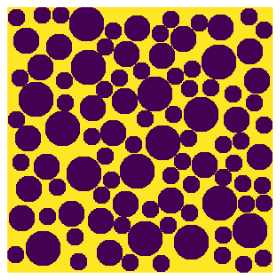

In [2]:
im = np.zeros([300, 300])
im = ps.generators.rsa(im, r=20, volume_fraction=0.2)
im = ps.generators.rsa(im, r=15, volume_fraction=0.4)
im = ps.generators.rsa(im, r=10, volume_fraction=0.6)
im = im == 0
fig, ax = plt.subplots()
ax.imshow(im, interpolation='none', origin='lower')
ax.axis(False);

## Apply Local Thickness Filter
The local thickness filter is called by simply passing in the image.  Like all filters in PoreSpy it is applied to the foreground, indicated by 1's or ``True``:

  0%|          | 0/25 [00:00<?, ?it/s]

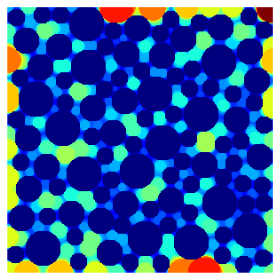

In [3]:
thk = ps.filters.local_thickness(im, mode='dt')
fig, ax = plt.subplots()
ax.imshow(thk, interpolation='none', origin='lower', cmap=plt.cm.jet)
ax.axis(False);

## Extracting PSD as a Histogram
Obtaining pore size distribution information from this image requires obtaining a histogram of voxel values.  A function in the ``metrics`` module does this for us:

In [4]:
psd = ps.metrics.pore_size_distribution(im=thk)

This function, like many of the functions in the ``metrics`` module, returns several arrays lumped together on a single object.  The advantage of this is that each array can be accessed by name as attributes, such as ``psd.pdf``.  To see all the available attributes (i.e. arrays) use the autocomplete function if your IDE supports it, or just print it as follows:

In [5]:
print(psd)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Item                      Description
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
LogR                      Array of size (10,)
pdf                       Array of size (10,)
cdf                       Array of size (10,)
satn                      Array of size (10,)
bin_centers               Array of size (10,)
bin_edges                 Array of size (11,)
bin_widths                Array of size (10,)
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's plot a pore-size distribution histogram:

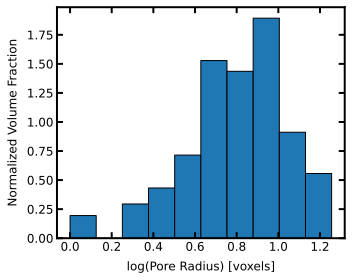

In [6]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_xlabel('log(Pore Radius) [voxels]')
ax.set_ylabel('Normalized Volume Fraction')
ax.bar(x=psd.LogR, height=psd.pdf, width=psd.bin_widths, edgecolor='k');

## PoreSpy Implementation
The ``local_thickness`` filter in PoreSpy is implemented differently that the *normal* approach such as the ImageJ plugin, though the end result is comparible though not identical.  

In our approach, we use a form of image dilation and erosion.  We start with a large spherical structuring element, and note all the places where this fits in the pore space.  This gives a result like that below for a structuring element of radius R=10:

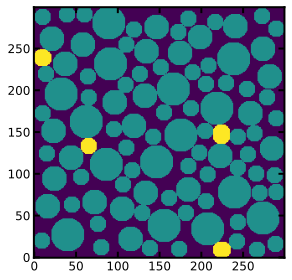

In [7]:
R = 10 
strel = ps.tools.ps_disk(R)
im_temp = spim.binary_opening(im, structure=strel)
fig, ax = plt.subplots()
ax.imshow(im_temp*2.0 + ~im, interpolation='none', origin='lower');

The key is to make a *master* array containing the numerical value of the largest sphere that covers each voxel.  We'll initialize a new array with the current locations where R=10 fits:

In [8]:
im_result = im_temp*R

Now this is repeated for a range of decreasing structuring element sizes.  For illustration, do R = 8:

In [9]:
R = 8
strel = ps.tools.ps_disk(R)
im_temp = spim.binary_opening(im, structure=strel)

This new image must be added to the ``im_result`` array, but only in places that were not filled at any larger radius.  This is done using boolean logic as follows:

In [10]:
im_result[(im_result == 0)*im_temp] = R

There are now 2 values in the ``im_results`` array indicating the locations where the structuring element of size 10 fits, and where size 8 fit on the subsequent step:

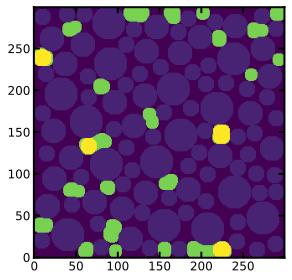

In [11]:
fig, ax = plt.subplots()
ax.imshow(im_result + ~im, interpolation='none', origin='lower');

The procedure is then repeated for smaller structuring elements down to R = 1.  It's possible to specify which sizes are used, but by default all integers between $R_{max}$ and 1.  This yields the image showed above:

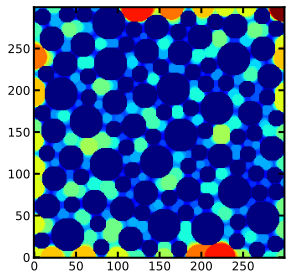

In [12]:
fig, ax = plt.subplots()
ax.imshow(thk, cmap=plt.cm.jet, interpolation='none', origin='lower');